### 加载数据集

In [ ]:
import os
import torch
import pandas as pd
import matplotlib
import sklearn
import transformers

!python --version
print(f"os          : {os.name}")
print(f"torch       : {torch.__version__}")
print(f"pandas      : {pd.__version__}")
print(f"matplotlib  : {matplotlib.__version__}")
print(f"sklearn     : {sklearn.__version__}")
print(f"transformers: {transformers.__version__}")

Python 3.11.12
os          : posix
torch       : 2.6.0+cu124
pandas      : 2.2.2
matplotlib  : 3.10.0
sklearn     : 1.6.1
transformers: 4.51.3


In [1]:
# 仅当无数据与模型时运行

!git clone https://hf-mirror.com/datasets/stanfordnlp/imdb /content/data/imdb
!git clone https://hf-mirror.com/datasets/stanfordnlp/sst2 /content/data/sst2

# model
!git clone https://hf-mirror.com/google-bert/bert-base-uncased /content/model/bert-base-uncased


Cloning into '/content/data/imdb'...
remote: Enumerating objects: 63, done.
remote: Total 63 (delta 0), reused 0 (delta 0), pack-reused 63 (from 1)
Unpacking objects: 100% (63/63), 12.80 KiB | 291.00 KiB/s, done.
Filtering content: 100% (3/3), 79.58 MiB | 29.71 MiB/s, done.
Cloning into '/content/data/sst2'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 35 (delta 12), reused 35 (delta 12), pack-reused 0 (from 0)
Unpacking objects: 100% (35/35), 8.40 KiB | 307.00 KiB/s, done.
Cloning into '/content/model/bert-base-uncased'...
remote: Enumerating objects: 85, done.
remote: Total 85 (delta 0), reused 0 (delta 0), pack-reused 85 (from 1)
Unpacking objects: 100% (85/85), 330.58 KiB | 831.00 KiB/s, done.
Filtering content: 100% (7/7), 3.21 GiB | 40.96 MiB/s, done.


In [21]:
from google.colab import drive
import shutil
#
drive.mount("/content/drive/")

srcA = "./model/bert-base-uncased-mlm"
destA = "/content/drive/MyDrive/bert-base-uncased-mlm"

srcB = "./model/bert-base-uncased-mlm.bin"
srcC = "./model/bert-base-uncased-e2e.bin"
destB = "/content/drive/MyDrive/bert-base-uncased-mlm.bin"
destC = "/content/drive/MyDrive/bert-base-uncased-e2e.bin"
#shutil.copytree(srcA, destA)
#shutil.copytree(destA, srcA)
shutil.copy(srcB, destB)
#shutil.copy(destB, srcB)
#shutil.copy(srcC, destC)
#shutil.copy(destC, srcC)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


'/content/drive/MyDrive/bert-base-uncased-mlm.bin'

In [ ]:
#%pip install fastparquet

In [3]:
import os
import re
import torch
import string
import random
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, BertModel, BertForMaskedLM, DataCollatorForLanguageModeling
from torch.optim import AdamW   # transformers 里的 AdamW 不再被推荐

IMDB_PATH = "./data/imdb/plain_text/"
IMDB_TRAIN = IMDB_PATH + "train-00000-of-00001.parquet"
IMDB_TEST = IMDB_PATH + "test-00000-of-00001.parquet"
IMDB_UNSUPERVISED = IMDB_PATH + "unsupervised-00000-of-00001.parquet"   # 无标签数据，拿来做Task2的语料训练

SST2_PATH = "./data/sst2/data/"
SST2_TRAIN = SST2_PATH + "train-00000-of-00001.parquet"
SST2_TEST = SST2_PATH + "test-00000-of-00001.parquet"
SST2_VALID = SST2_PATH + "validation-00000-of-00001.parquet"

MODEL_PATH = "./model/bert-base-uncased"
MODEL_E2E_NAME = "./model/bert-base-uncased-e2e.bin"
MODEL_PRE_NAME = "./model/bert-base-uncased-mlm.bin"
MODEL_PRE_PATH = "./model/bert-base-uncased-mlm"

MAX_LENGTH = 128 # 不超过512
BATCH_SIZE = 128 # 为128以上时会导致colab崩溃
LEARNING_RATE = 5e-5
EPOCHS = 20
NUM_LABELS = 2

In [1]:
!nvidia-smi
device = torch.device("cuda")
print(f"Using device: {torch.cuda.get_device_name(0)}")
if torch.cuda.get_device_capability(0)[0] >= 7:
    print("[INFO] 支持混合精度")
else:
    print("[WARNING] 不支持混合精度")

Sun Apr 27 09:35:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 数据预处理

In [4]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)                                 # 去除HTML标签
    text = text.translate(str.maketrans('', '', string.punctuation))  # 去除标点符号
    text = text.lower()                                               # 转为小写（uncased模型需要）
    text = re.sub(r'\s+', ' ', text).strip()                          # 去除多余空格
    return text
def preprocess_dataset(df, ds_type="SST2", is_MLM=False):
    row_name="sentence" if ds_type == "SST2" else "text"
    df["text"] = df[row_name].apply(clean_text)
    if not is_MLM:
        data_list = df[["text", "label"]].to_dict(orient="records")
        print(df["label"].value_counts(normalize=True))
    else:
        data_list = df["text"].to_list()
    return data_list

In [ ]:
tmptestimdb = pd.read_parquet(IMDB_TRAIN)
tmptesttest = pd.read_parquet(IMDB_TEST)
tmpunsupervised = pd.read_parquet(IMDB_UNSUPERVISED)

print(tmptestimdb.head())
print(tmpunsupervised.head())
print(f"训练集长度: {len(tmptestimdb)}; 测试集长度: {len(tmptesttest)}; 无标签数据长度: {len(tmpunsupervised)}")

train_texts = set(tmptestimdb['text'])
test_texts = set(tmptesttest['text'])
common_texts = train_texts.intersection(test_texts)

if len(common_texts) > 0:
    print(f"警告：训练集和测试集有 {len(common_texts)} 条重复样本！")
else:
    print("训练集和测试集完全不同。")

imdb_list_ = preprocess_dataset(tmptestimdb, ds_type="IMDB")
print(imdb_list_[:1])

                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0
                                                text  label
0  This is just a precious little diamond. The pl...     -1
1  When I say this is my favourite film of all ti...     -1
2  I saw this movie because I am a huge fan of th...     -1
3  Being that the only foreign films I usually li...     -1
4  After seeing Point of No Return (a great movie...     -1
训练集长度: 25000; 测试集长度: 25000; 无标签数据长度: 50000
警告：训练集和测试集有 123 条重复样本！
label
0    0.5
1    0.5
Name: proportion, dtype: float64
[{'text': 'i rented i am curiousyellow from my video store because of all the controversy that surrounded it when it was first released in 1967 i also heard 

In [ ]:
tmptestsst2 = pd.read_parquet(SST2_TRAIN)
tmptestsst2_valid = pd.read_parquet(SST2_VALID)
tmptestsst2_test = pd.read_parquet(SST2_TEST)

print(tmptestsst2.head())
print(tmptestsst2_test.head())

print(f"训练集长度: {len(tmptestsst2)}; 验证集长度: {len(tmptestsst2_valid)}; 测试集长度: {len(tmptestsst2_test)}")

train_texts = set(tmptestsst2['sentence'])
valid_texts = set(tmptestsst2_valid['sentence'])
common_texts = train_texts.intersection(valid_texts)

if len(common_texts) > 0:
    print(f"警告：训练集和验证集有 {len(common_texts)} 条重复样本！")
else:
    print("训练集和验证集完全不同。")

sst2_list_ = preprocess_dataset(tmptestsst2)

print(sst2_list_[:5])

   idx                                           sentence  label
0    0       hide new secretions from the parental units       0
1    1               contains no wit , only labored gags       0
2    2  that loves its characters and communicates som...      1
3    3  remains utterly satisfied to remain the same t...      0
4    4  on the worst revenge-of-the-nerds clichés the ...      0
   idx                                           sentence  label
0    0             uneasy mishmash of styles and genres .     -1
1    1  this film 's relationship to actual tension is...     -1
2    2  by the end of no such thing the audience , lik...     -1
3    3  director rob marshall went out gunning to make...     -1
4    4  lathan and diggs have considerable personal ch...     -1
训练集长度: 67349; 验证集长度: 872; 测试集长度: 1821
训练集和验证集完全不同。
label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
[{'text': 'hide new secretions from the parental units', 'label': 0}, {'text': 'contains no wit only l

In [5]:
'''
IMDB只有训练集和验证集，SST2的测试集也都没有标注
因此这里先统一处理，将训练集和验证集合并后再统一划分，并且确保划分后三个数据集中的标签分布与原数据集（这里指合并后的）
    需要注意的是IMDB的训练集和验证集有123条重复数据（这里因为没用到所以就先不管）
'''
def init_data(is_MLM=False, is_check=False):
    train_data = preprocess_dataset(pd.read_parquet(SST2_TRAIN), ds_type="SST2")
    val_data = preprocess_dataset(pd.read_parquet(SST2_VALID), ds_type="SST2")
    combined_data = train_data + val_data
    labels = [item["label"] for item in combined_data]

    # 训练：测试+验证 = 8:2
    train_data, temp_data = train_test_split(
        combined_data, test_size=0.2, random_state=42, stratify=labels
    )

    temp_labels = [item["label"] for item in temp_data]
    # 验证：测试 = 1:1
    val_data, test_data = train_test_split(
        temp_data, test_size=0.5, random_state=42, stratify=temp_labels
    )

    # 无监督训练用不到测试集，把原有的训练集和验证集覆盖，保留正式数据划分好的测试集
    if is_MLM:
        combined_data = preprocess_dataset(pd.read_parquet(IMDB_UNSUPERVISED), ds_type="IMDB", is_MLM=True)
        train_data, val_data = train_test_split(
            combined_data, test_size=0.2, random_state=42
        )
    if is_check:
      pass
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)

    print(f"训练集长度: {len(train_data)}; 验证集长度: {len(val_data)}; 测试集长度: {len(test_data)}")

#     print("[DEBUG] Train:")
#     for item in train_data[:5]:
#         print(item)
#
#     print("\n[DEBUG] Validation:")
#     for item in val_data[:5]:
#         print(item)
#
#     print("\n[DEBUG] Test:")
#     for item in test_data[:5]:
#         print(item)

    return train_data, val_data, test_data
if __name__ == "__main__":
    init_data(is_MLM=False, is_check=True)   # SST2 合并后的分布大致为 0: 0.4428, 1: 0.5572

label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64
训练集长度: 54576; 验证集长度: 6822; 测试集长度: 6823


In [6]:
# data_list是经过预处理的列表，每项包含 text 和 label
class SentimentDataset(Dataset):
    def __init__(self, data_list, tokenizer, max_length=MAX_LENGTH, is_MLM=False):
        self.data = data_list
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.is_MLM = is_MLM

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if not self.is_MLM:
            text = self.data[idx]["text"]
        else:
            text = self.data[idx]   # MLM 只有一列

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,    # 加上 [CLS]（开头） 和 [SEP]（结尾），不够的用[PAD]填充
            max_length=self.max_length, # 输入序列的最大长度 <-- Enron-Spam二分类里遇到过
            padding="max_length",
            truncation=True,            # 启用截断
            return_tensors="pt"
        )
        if not self.is_MLM:
            return {key: val.squeeze(0) for key, val in encoding.items()}, torch.tensor(self.data[idx]["label"])

        return {key: val.squeeze(0) for key, val in encoding.items()}

# 这个运行挺快的，就不缓存了（之前做Enrom-Spam的时候分词一次20分钟）
def load_data(tokenizer, is_MLM=False, is_check=False):
    train_data, val_data, test_data = init_data(is_MLM, is_check=is_check)
    train_dataset = SentimentDataset(train_data, tokenizer, is_MLM=is_MLM)
    val_dataset = SentimentDataset(val_data, tokenizer, is_MLM=is_MLM)
    test_dataset = SentimentDataset(test_data, tokenizer)
    if is_check:
      test_loader = DataLoader(test_dataset, batch_size=1024)
    else:
      test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # 自动处理掩码，随机掩码（默认15%的）token并使用原始input_ids作为labels（非掩码位置设为-100以忽略损失）
    collate_fn = None if not is_MLM else DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=2, pin_memory=True)
    # for batch in train_loader:
    #    inputs, labels = batch
    #    print("Inputs:", inputs)
    #    print("Labels:", labels)
    #    break

    return train_loader, val_loader, test_loader

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
train_loader, val_loader, test_loader = load_data(tokenizer)

label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64
训练集长度: 54576; 验证集长度: 6822; 测试集长度: 6823


### 训练器与测试器

在`colab`上训练时每个`batch`都至少输出一条信息，不然会因为长时间无响应而断开连接

In [7]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, epochs=3, lr=2e-5, is_MLM=False):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.is_MLM = is_MLM
        self.epochs = epochs
        self.lr = lr

        # AdamW 是加入了权重衰减的Adam
        self.optimizer = AdamW(self.model.parameters(), lr=lr)
        # 学习率从0增加到设定的最大值然后逐渐线性下降
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=2,
            num_training_steps=len(train_loader)*epochs
        )
        self.loss_func = nn.CrossEntropyLoss()
        # 拓展：混合精度训练
        self.scaler = torch.amp.GradScaler(device=self.device.type)

        # 训练记录
        self.train_losses, self.val_losses = [], []
        self.train_accs, self.val_accs = [], []
        self.train_precisions, self.val_precisions = [], []
        self.train_recalls, self.val_recalls = [], []
        self.train_f1s, self.val_f1s = [], []
        self.best_accuracy = 0.0
        self.min_loss = float("inf")
        self.save_name = MODEL_E2E_NAME
        self.bear_cnt = 0
        self.epc=1
        self.mlm_loss_train = []
        self.mlm_loss_valid = []

        # print(f"[DEBUG] train loader length:{len(self.train_loader)}")

    def train(self):
        for epoch in range(self.epochs):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            # 训练
            # print(f"[DEBUG] train")
            train_loss, train_acc, train_precision, train_recall, train_f1 = self.__train_part()

            # 验证
            # print(f"[DEBUG] valid")
            val_loss, val_acc, val_precision, val_recall, val_f1 = self._valid_part()
            self.epc+=1

            # 保存最佳模型
            if not self.is_MLM and val_acc > self.best_accuracy:
                self.best_accuracy = val_acc
                self.bear_cnt=0
                torch.save(self.model.state_dict(), self.save_name)
            if val_loss < self.min_loss:
                self.min_loss = val_loss
                self.bear_cnt = 0
            else:
                self.bear_cnt += 1
                if self.bear_cnt >= 3:
                    print("[INFO] Early stop")
                    break

            print(f"Epoch {epoch + 1}/{self.epochs}")
            print(
                f"Train Loss: {train_loss:.4f}, "
                f"Acc: {f'{train_acc:.4f}'             if train_acc       is not None else 'N/A'}, "
                f"Precision: {f'{train_precision:.4f}' if train_precision is not None else 'N/A'}, "
                f"Recall: {f'{train_recall:.4f}'       if train_recall    is not None else 'N/A'}, "
                f"F1: {f'{train_f1:.4f}'               if train_f1        is not None else 'N/A'} | "
                f"Val Loss: {val_loss:.4f}, "
                f"Acc: {f'{val_acc:.4f}'               if val_acc         is not None else 'N/A'}, "
                f"Precision: {f'{val_precision:.4f}'   if val_precision   is not None else 'N/A'}, "
                f"Recall: {f'{val_recall:.4f}'         if val_recall      is not None else 'N/A'}, "
                f"F1: {f'{val_f1:.4f}'                 if val_f1          is not None else 'N/A'}"
            )

        return (
            self.train_losses,
            self.val_losses,
            self.train_accs,
            self.val_accs,
            self.train_precisions,
            self.val_precisions,
            self.train_recalls,
            self.val_recalls,
            self.train_f1s,
            self.val_f1s,
        )

    def __train_part(self):
        # print(f"[DEBUG] jump into __train_part")
        self.model.train()
        # print(f"[DEBUG] {self.model.training}")
        total_loss = 0.0
        all_labels = []
        all_preds = []
        cc=1
        for batch in self.train_loader:
            print(f"[DEBUG] batch/epoch: {cc}/{self.epc}")
            cc+=1
            if not self.is_MLM:
                inputs, labels = batch
                # print(f"[DEBUG] {inputs}")
                # print(f"[DEBUG] {labels}")
                labels = labels.to(self.device)
            else:
                inputs = batch
                labels = inputs["input_ids"].to(self.device)

            input_ids = inputs["input_ids"].to(self.device)
            attention_mask = inputs["attention_mask"].to(self.device)

            # print(f"[DEBUG] {input_ids.shape}")
            # print(f"[DEBUG] {attention_mask.shape}")
            # 拓展： 混合精度前向传播
            with torch.amp.autocast(device_type=self.device.type):
                if not self.is_MLM:
                    outputs = self.model(input_ids=input_ids,attention_mask=attention_mask)
                    # print(f"[DEBUG] {outputs}")
                    loss = self.loss_func(outputs, labels)
                else:
                    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss # MLM内含loss

            # print(f"[DEBUG] {loss.item()}")

            self.optimizer.zero_grad()
            #loss.backward()
            self.scaler.scale(loss).backward()  # 反向传播前对loss乘一个缩放因子，避免梯度过小导致的下溢
            self.scaler.unscale_(self.optimizer)  # 反缩放，梯度裁剪通常是基于原始梯度值进行的
            # 梯度裁剪 <-- 防止爆炸、稳定训练、加速收敛
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            #self.optimizer.step()
            self.scaler.step(self.optimizer)
            self.scaler.update()  # 更新缩放因子，为下次迭代做准备
            self.scheduler.step()

            if self.is_MLM:
                self.mlm_loss_train.append(loss.item())
            total_loss += loss.item()
            if not self.is_MLM:
                tmp = torch.softmax(outputs, dim=1)
                preds = torch.argmax(tmp, dim=1).cpu().numpy()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds)

        train_loss = total_loss / len(self.train_loader)

        if not self.is_MLM:
            train_acc = accuracy_score(all_labels, all_preds)
            train_precision = precision_score(all_labels, all_preds, average="weighted")
            train_recall = recall_score(all_labels, all_preds, average="weighted")
            train_f1 = f1_score(all_labels, all_preds, average="weighted")

            # 保存记录
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            self.train_precisions.append(train_precision)
            self.train_recalls.append(train_recall)
            self.train_f1s.append(train_f1)
            return train_loss, train_acc, train_precision, train_recall, train_f1
        else:
            return train_loss, None, None, None, None

    def _valid_part(self):
        self.model.eval()
        total_loss = 0.0
        all_labels = []
        all_preds = []
        cc=1
        with torch.no_grad():
            for batch in self.val_loader:
                print(f"[DEBUG] batch/epoch: {cc}/{self.epc}")
                cc+=1
                if not self.is_MLM:
                    inputs, labels = batch
                    labels = labels.to(self.device)
                else:
                    inputs = batch
                    labels = inputs["input_ids"].to(self.device)

                input_ids = inputs["input_ids"].to(self.device)
                attention_mask = inputs["attention_mask"].to(self.device)

                # 拓展： 混合精度前向传播
                with torch.amp.autocast(device_type=self.device.type):
                    if not self.is_MLM:
                        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                        loss = self.loss_func(outputs, labels)
                    else:
                        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                        loss = outputs.loss

                if self.is_MLM:
                    self.mlm_loss_valid.append(loss.item())

                total_loss += loss.item()
                if not self.is_MLM:
                    tmp = torch.softmax(outputs, dim=1)
                    preds = torch.argmax(tmp, dim=1).cpu().numpy()
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds)

        val_loss = total_loss / len(self.val_loader)

        if not self.is_MLM:
            val_acc = accuracy_score(all_labels, all_preds)
            val_precision = precision_score(all_labels, all_preds, average="weighted")
            val_recall = recall_score(all_labels, all_preds, average="weighted")
            val_f1 = f1_score(all_labels, all_preds, average="weighted")

            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)
            self.val_precisions.append(val_precision)
            self.val_recalls.append(val_recall)
            self.val_f1s.append(val_f1)

            return val_loss, val_acc, val_precision, val_recall, val_f1
        else:
            return val_loss, None, None, None, None

In [8]:
class ModelEvaluator:
    def __init__(
        self,
        test_loader=None,
        compare_lists=None,
    ):
        self.test_loader = test_loader
        self.compare_lists = compare_lists
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fpr= None
        self.tpr= None
        self.roc_auc= None

    def evaluate_model(self, model, analyse=True, is_check=False):
        model.to(self.device)
        model.eval()

        all_labels = []
        all_preds = []
        cc=0
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                print(f"[DEBUG] Testing batch:{cc}")
                cc+=1
                inputs = {key: val.to(self.device) for key, val in inputs.items()}
                labels = labels.to(self.device)
                outputs= model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
                tmp = torch.softmax(outputs, dim=1)
                preds = torch.argmax(tmp, dim=1).tolist()

                all_labels.extend(labels.tolist())
                all_preds.extend(preds)

        # 计算评估指标
        test_acc = accuracy_score(all_labels, all_preds)
        test_precision = precision_score(all_labels, all_preds)
        test_recall = recall_score(all_labels, all_preds)
        test_f1 = f1_score(all_labels, all_preds)
        self.fpr, self.tpr, _ = roc_curve(all_labels, all_preds)
        self.roc_auc = auc(self.fpr, self.tpr)

        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test Precision: {test_precision:.4f}")
        print(f"Test Recall: {test_recall:.4f}")
        print(f"Test F1 Score: {test_f1:.4f}")

        # 绘制混淆矩阵
        cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=["Negtive", "Postive"]
        )
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

        if analyse:
            return test_acc, test_precision, test_recall, test_f1

    def collect_errors(self, model, tokenizer):
        model.to(self.device)
        model.eval()

        errors = []  # 存储错误分类的样本
        cc=1
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                print(f"[DEBUG] Testing batch:{cc}")
                cc+=1
                inputs = {key: val.to(self.device) for key, val in inputs.items()}
                labels = labels.to(self.device)

                # 模型预测
                outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(probs, dim=1)

                # 收集错误分类的样本
                for i in range(len(labels)):
                    if preds[i] != labels[i]:
                        text = tokenizer.decode(inputs["input_ids"][i], skip_special_tokens=True)
                        errors.append({
                            "text": text,
                            "label": labels[i].item(),
                            "pred": preds[i].item()
                        })

        return errors

### 模型结构

直接将 `bert-base-uncased` 作为基础编码器，接上分类层（全连接层+softmax/sigmoid激活）

这里只返回`logits`，具体


In [ ]:
bert_out = BertModel.from_pretrained(MODEL_PATH).config.hidden_size
print(f"bert_out: {bert_out}")

bert_out: 768


In [9]:
class BertClassifier(nn.Module):
    def __init__(self, mlm=False):
        super(BertClassifier, self).__init__()
        model_path = MODEL_PATH if not mlm else MODEL_PRE_PATH
        self.bert = BertModel.from_pretrained(model_path)

        self.dropout = nn.Dropout(0.6)
        self.classifier = nn.Linear(self.bert.config.hidden_size, NUM_LABELS)  # 分类层
        #self.activation = nn.Sigmoid() # 二分类

    def forward(self, input_ids, attention_mask):
        # BERT 编码器
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask # 区别有效区域与填充区域
        )
        # 基于 [CLS] token 的隐藏状态，经过一个额外的全连接层和 tanh 激活函数后的结果
        cls_output = outputs.pooler_output

        # Dropout + 分类层
        #cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

In [ ]:
#model = BertForSequenceClassification.from_pretrained(MODEL_PATH, num_labels=NUM_LABELS)

In [10]:
def compare_eval(initial_metrics, final_metrics):
    # 对比前后的性能变化
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
    initial_values = [initial_metrics[0], initial_metrics[1], initial_metrics[2], initial_metrics[3]]
    final_values = [final_metrics[0], final_metrics[1], final_metrics[2], final_metrics[3]]

    x = range(len(metrics))
    plt.figure(figsize=(8, 6))
    plt.bar(x, initial_values, width=0.4, label="Before Fine-tuning", align="center")
    plt.bar([i + 0.4 for i in x], final_values, width=0.4, label="After Fine-tuning", align="center")
    plt.xticks([i + 0.2 for i in x], metrics)
    plt.ylabel("Score")
    plt.title("Performance Comparison Before and After Fine-tuning")
    plt.legend()
    plt.show()

def train_show(trainer):
    plt.figure(figsize=(15, 10))

    # 准确率
    plt.subplot(2, 3, 1)
    plt.plot(trainer.train_accs, label="Train Accuracy")
    plt.plot(trainer.val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    # 精确率
    plt.subplot(2, 3, 2)
    plt.plot(trainer.train_precisions, label="Train Precision")
    plt.plot(trainer.val_precisions, label="Validation Precision")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.title("Training and Validation Precision")
    plt.legend()

    # 损失
    plt.subplot(2, 3, 3)
    plt.plot(trainer.train_losses, label="Train Loss")
    plt.plot(trainer.val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    # 召回率
    plt.subplot(2, 3, 4)
    plt.plot(trainer.train_recalls, label="Train Recall")
    plt.plot(trainer.val_recalls, label="Validation Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title("Training and Validation Recall")
    plt.legend()

    # F1
    plt.subplot(2, 3, 5)
    plt.plot(trainer.train_f1s, label="Train F1")
    plt.plot(trainer.val_f1s, label="Validation F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Training and Validation F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

#### 端到端训练

加载预训练权重，更新整个网络的参数

情感二分类任务对于两种情感并没有明显倾向，类别分布也比较均衡，这里重点关注准确率（`acc`）

label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64
训练集长度: 54576; 验证集长度: 6822; 测试集长度: 6823
端到端微调前的性能：
Test Accuracy: 0.4434
Test Precision: 0.7500
Test Recall: 0.0016
Test F1 Score: 0.0031


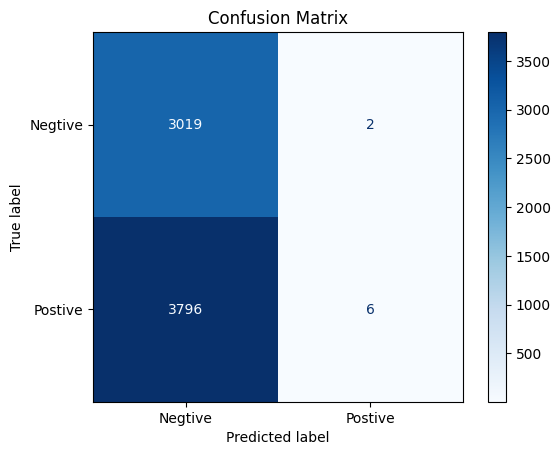

In [ ]:
# 初始化模型和数据
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier()
model.to(device)
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
train_loader, val_loader, test_loader = load_data(tokenizer)

trainer = ModelTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)

evaluator = ModelEvaluator(test_loader=test_loader)
print("端到端微调前的性能：")
initial_metrics = evaluator.evaluate_model(model=model)

[DEBUG] batch/epoch: 1/1
[DEBUG] batch/epoch: 2/1
[DEBUG] batch/epoch: 3/1
[DEBUG] batch/epoch: 4/1
[DEBUG] batch/epoch: 5/1
[DEBUG] batch/epoch: 6/1
[DEBUG] batch/epoch: 7/1
[DEBUG] batch/epoch: 8/1
[DEBUG] batch/epoch: 9/1
[DEBUG] batch/epoch: 10/1
[DEBUG] batch/epoch: 11/1
[DEBUG] batch/epoch: 12/1
[DEBUG] batch/epoch: 13/1
[DEBUG] batch/epoch: 14/1
[DEBUG] batch/epoch: 15/1
[DEBUG] batch/epoch: 16/1
[DEBUG] batch/epoch: 17/1
[DEBUG] batch/epoch: 18/1
[DEBUG] batch/epoch: 19/1
[DEBUG] batch/epoch: 20/1
[DEBUG] batch/epoch: 21/1
[DEBUG] batch/epoch: 22/1
[DEBUG] batch/epoch: 23/1
[DEBUG] batch/epoch: 24/1
[DEBUG] batch/epoch: 25/1
[DEBUG] batch/epoch: 26/1
[DEBUG] batch/epoch: 27/1
[DEBUG] batch/epoch: 28/1
[DEBUG] batch/epoch: 29/1
[DEBUG] batch/epoch: 30/1
[DEBUG] batch/epoch: 31/1
[DEBUG] batch/epoch: 32/1
[DEBUG] batch/epoch: 33/1
[DEBUG] batch/epoch: 34/1
[DEBUG] batch/epoch: 35/1
[DEBUG] batch/epoch: 36/1
[DEBUG] batch/epoch: 37/1
[DEBUG] batch/epoch: 38/1
[DEBUG] batch/epoch: 

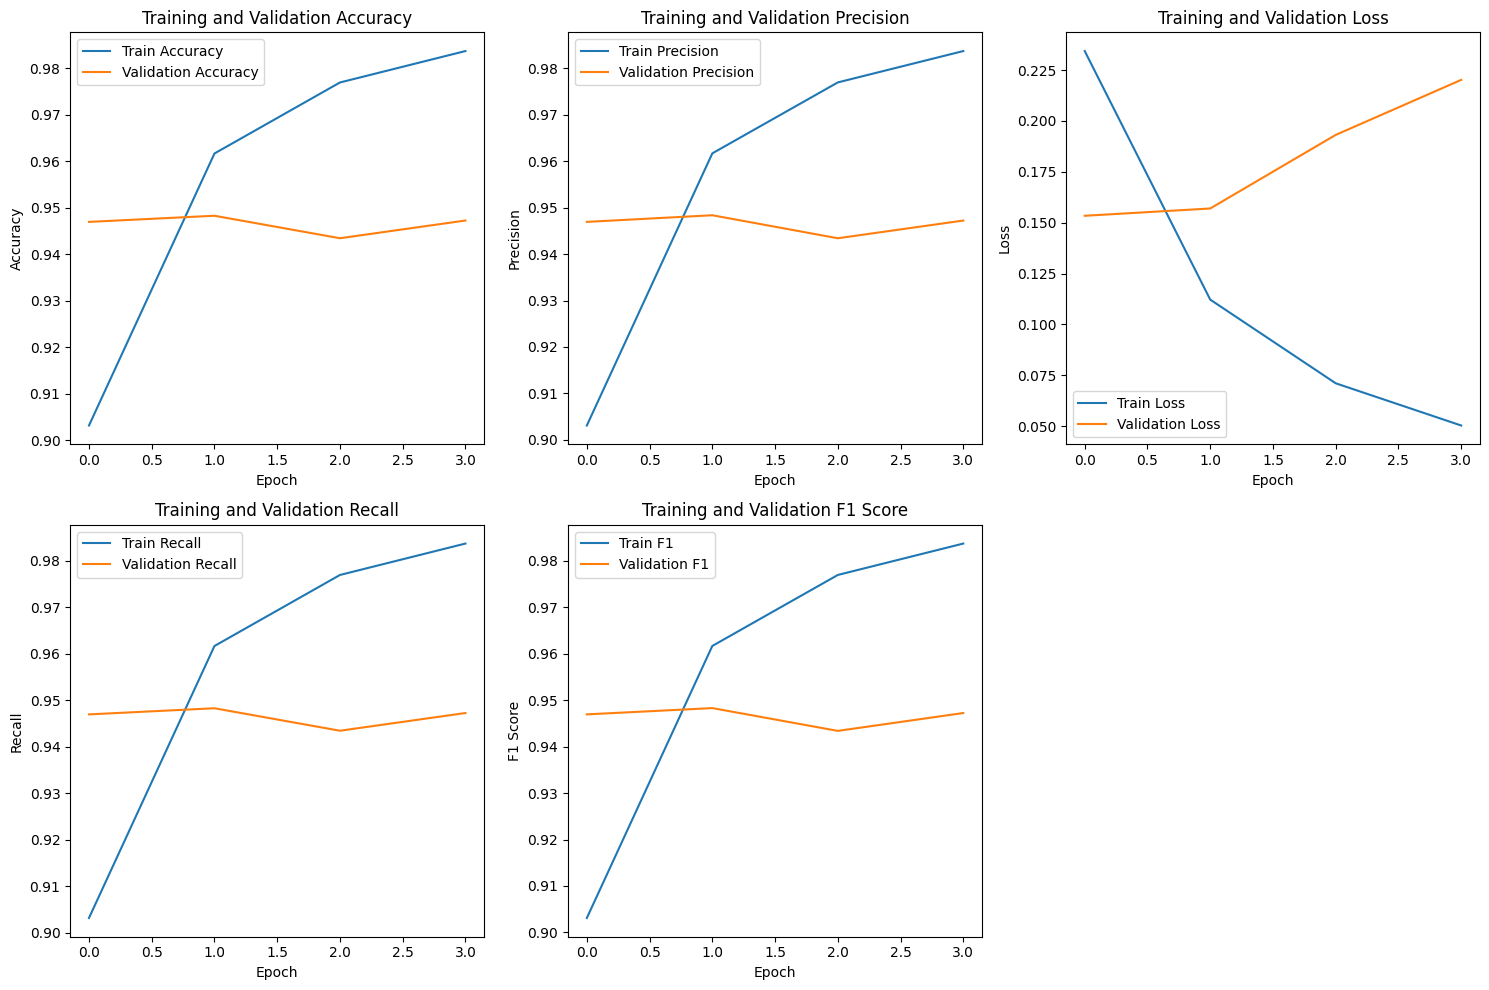

In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()
trainer.train()
train_show(trainer)

端到端微调后的性能：
Test Accuracy: 0.9431
Test Precision: 0.9455
Test Recall: 0.9529
Test F1 Score: 0.9492


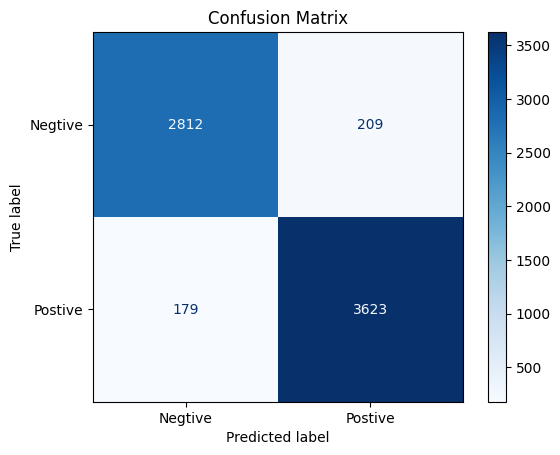

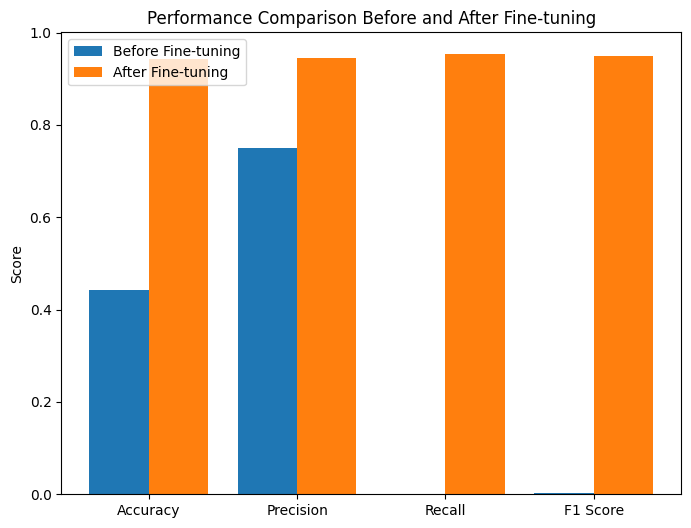

In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()

print("端到端微调后的性能：")
final_metrics = evaluator.evaluate_model(model=model)

# 对比端到端训练前后性能变化
compare_eval(initial_metrics, final_metrics)

#### 先预训练后微调

##### 预训练

In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()
# 加载预训练模型
is_MLM = True
model = BertForMaskedLM.from_pretrained(MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

train_loader, val_loader, test_loader = load_data(tokenizer, is_MLM)

mlm_trainer = ModelTrainer(model=model, train_loader=train_loader, val_loader=val_loader, epochs=2, lr=LEARNING_RATE, is_MLM=is_MLM)

# 损失在3.5以下（通用预训练MLM损失）比较正常
mlm_trainer.train()

model.save_pretrained(MODEL_PRE_PATH, safe_serialization=False)
tokenizer.save_pretrained(MODEL_PRE_PATH)

Some weights of the model checkpoint at ./model/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64
训练集长度: 40000; 验证集长度: 10000; 测试集长度: 6823
[DEBUG] batch/epoch: 1/1
[DEBUG] batch/epoch: 2/1
[DEBUG] batch/epoch: 3/1
[DEBUG] batch/epoch: 4/1
[DEBUG] batch/epoch: 5/1
[DEBUG] batch/epoch: 6/1
[DEBUG] batch/epoch: 7/1
[DEBUG] batch/epoch: 8/1
[DEBUG] batch/epoch: 9/1
[DEBUG] batch/epoch: 10/1
[DEBUG] batch/epoch: 11/1
[DEBUG] batch/epoch: 12/1
[DEBUG] batch/epoch: 13/1
[DEBUG] batch/epoch: 14/1
[DEBUG] batch/epoch: 15/1
[DEBUG] batch/epoch: 16/1
[DEBUG] batch/epoch: 17/1
[DEBUG] batch/epoch: 18/1
[DEBUG] batch/epoch: 19/1
[DEBUG] batch/epoch: 20/1
[DEBUG] batch/epoch: 21/1
[DEBUG] batch/epoch: 22/1
[DEBUG] batch/epoch: 23/1
[DEBUG] batch/epoch: 24/1
[DEBUG] batch/epoch: 25/1
[DEBUG] batch/epoch: 26/1
[DEBUG] batch/epoch: 27/1
[DEBUG] batch/epoch: 28/1
[DEBUG] batch/epoch: 29/1
[DEBUG] batch/epoch: 30/1
[DEBUG] batch/epoch: 31/1
[DEBUG] batch/epoch: 32/1
[DE

('./model/bert-base-uncased-mlm/tokenizer_config.json',
 './model/bert-base-uncased-mlm/special_tokens_map.json',
 './model/bert-base-uncased-mlm/vocab.txt',
 './model/bert-base-uncased-mlm/added_tokens.json')

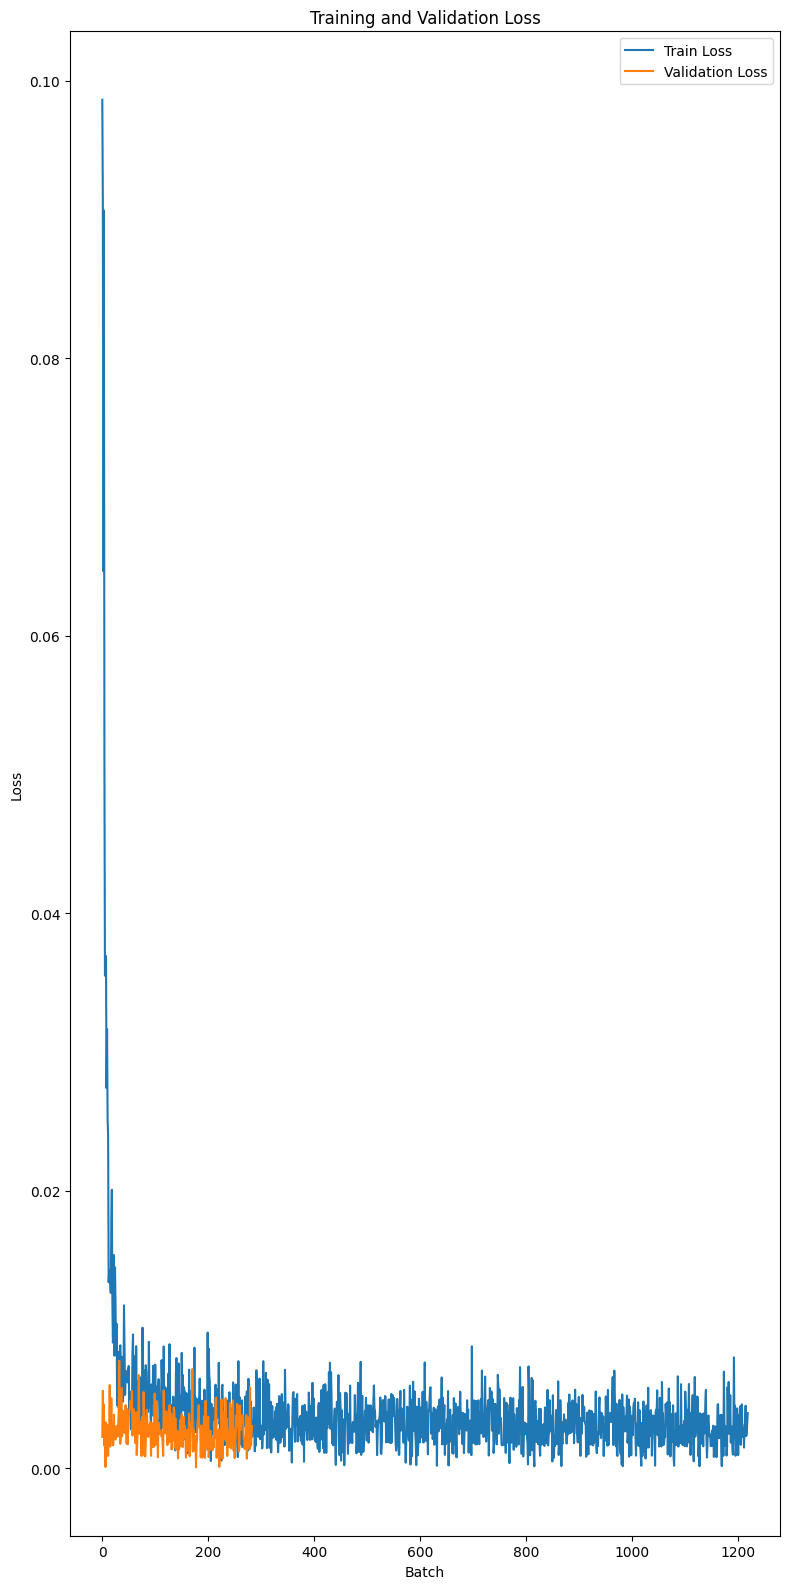

In [ ]:
plt.figure(figsize=(8, 16))
plt.plot(mlm_trainer.mlm_loss_train[30:], label="Train Loss")
plt.plot(mlm_trainer.mlm_loss_valid[30:], label="Validation Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

if torch.cuda.is_available():
    torch.cuda.empty_cache()

##### 微调

In [11]:
def layerwise_lr_decay(model, lr=5e-5, decay=0.8):
    # 分类头参数（学习率较高）
    # classifier_params = list(model.classifier.parameters()) + list(model.dropout.parameters())
    classifier_params = list(model.classifier.parameters())

    # BERT本体参数（学习率较低）
    bert_params = []
    bert_lr = lr *0.5
    for i, layer in enumerate(model.bert.encoder.layer[::-1]):  # 从最后一层开始
        bert_params.append({"params": layer.parameters(), "lr": bert_lr})
        bert_lr *= decay  # 每层学习率衰减

    # 分类头学习率较高，放在前面确保优化器优先处理
    return [{"params": classifier_params, "lr": lr}] + bert_params

In [12]:
# 初始化模型和数据
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier(mlm=True)
model.to(device)
tokenizer = BertTokenizer.from_pretrained(MODEL_PRE_PATH)
train_loader, val_loader, test_loader = load_data(tokenizer)

params = layerwise_lr_decay(model)
optimizer = AdamW(params, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=2, num_training_steps=len(train_loader) * EPOCHS
)

Some weights of BertModel were not initialized from the model checkpoint at ./model/bert-base-uncased-mlm and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64
训练集长度: 54576; 验证集长度: 6822; 测试集长度: 6823


微调前的性能：
[DEBUG] Testing batch:0
[DEBUG] Testing batch:1
[DEBUG] Testing batch:2
[DEBUG] Testing batch:3
[DEBUG] Testing batch:4
[DEBUG] Testing batch:5
[DEBUG] Testing batch:6
[DEBUG] Testing batch:7
[DEBUG] Testing batch:8
[DEBUG] Testing batch:9
[DEBUG] Testing batch:10
[DEBUG] Testing batch:11
[DEBUG] Testing batch:12
[DEBUG] Testing batch:13
[DEBUG] Testing batch:14
[DEBUG] Testing batch:15
[DEBUG] Testing batch:16
[DEBUG] Testing batch:17
[DEBUG] Testing batch:18
[DEBUG] Testing batch:19
[DEBUG] Testing batch:20
[DEBUG] Testing batch:21
[DEBUG] Testing batch:22
[DEBUG] Testing batch:23
[DEBUG] Testing batch:24
[DEBUG] Testing batch:25
[DEBUG] Testing batch:26
[DEBUG] Testing batch:27
[DEBUG] Testing batch:28
[DEBUG] Testing batch:29
[DEBUG] Testing batch:30
[DEBUG] Testing batch:31
[DEBUG] Testing batch:32
[DEBUG] Testing batch:33
[DEBUG] Testing batch:34
[DEBUG] Testing batch:35
[DEBUG] Testing batch:36
[DEBUG] Testing batch:37
[DEBUG] Testing batch:38
[DEBUG] Testing batch:39
[D

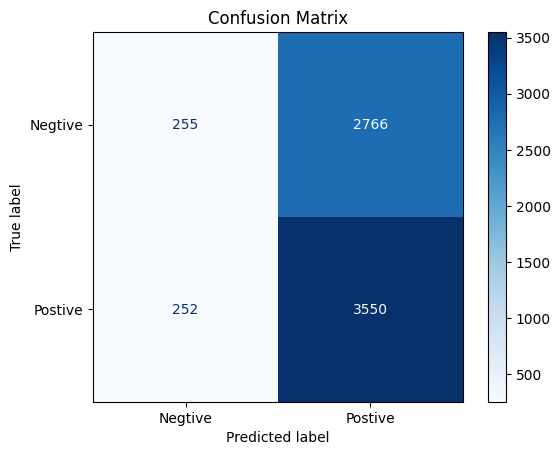

In [13]:
# 初始化训练器
trainer = ModelTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    lr=5e-5,
)
trainer.optimizer = optimizer  # 覆盖默认优化器 <-- 引入分层学习率
trainer.scheduler = scheduler
trainer.save_name = MODEL_PRE_NAME

evaluator = ModelEvaluator(test_loader=test_loader)
print("微调前的性能：")
initial_metrics = evaluator.evaluate_model(model=model)

流式输出内容被截断，只能显示最后 5000 行内容。
[DEBUG] batch/epoch: 316/10
[DEBUG] batch/epoch: 317/10
[DEBUG] batch/epoch: 318/10
[DEBUG] batch/epoch: 319/10
[DEBUG] batch/epoch: 320/10
[DEBUG] batch/epoch: 321/10
[DEBUG] batch/epoch: 322/10
[DEBUG] batch/epoch: 323/10
[DEBUG] batch/epoch: 324/10
[DEBUG] batch/epoch: 325/10
[DEBUG] batch/epoch: 326/10
[DEBUG] batch/epoch: 327/10
[DEBUG] batch/epoch: 328/10
[DEBUG] batch/epoch: 329/10
[DEBUG] batch/epoch: 330/10
[DEBUG] batch/epoch: 331/10
[DEBUG] batch/epoch: 332/10
[DEBUG] batch/epoch: 333/10
[DEBUG] batch/epoch: 334/10
[DEBUG] batch/epoch: 335/10
[DEBUG] batch/epoch: 336/10
[DEBUG] batch/epoch: 337/10
[DEBUG] batch/epoch: 338/10
[DEBUG] batch/epoch: 339/10
[DEBUG] batch/epoch: 340/10
[DEBUG] batch/epoch: 341/10
[DEBUG] batch/epoch: 342/10
[DEBUG] batch/epoch: 343/10
[DEBUG] batch/epoch: 344/10
[DEBUG] batch/epoch: 345/10
[DEBUG] batch/epoch: 346/10
[DEBUG] batch/epoch: 347/10
[DEBUG] batch/epoch: 348/10
[DEBUG] batch/epoch: 349/10
[DEBUG] batch/epoch: 

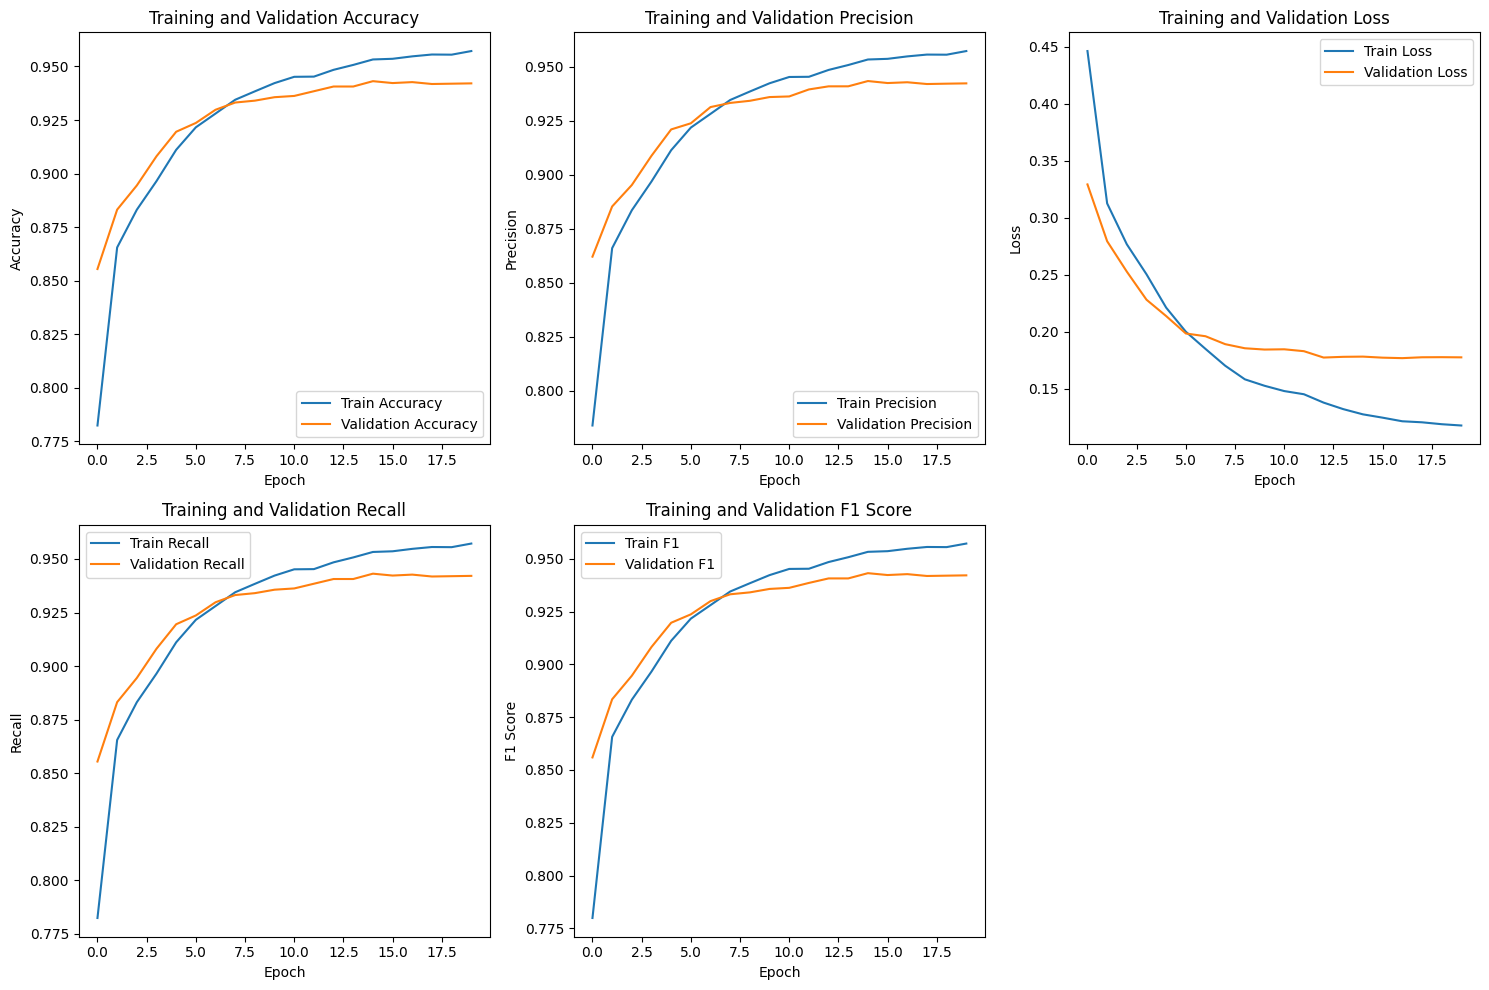

In [14]:
if torch.cuda.is_available():
    import time
    torch.cuda.empty_cache()
    start_time = time.time()
    torch.cuda.reset_peak_memory_stats()
    initial_memory = torch.cuda.memory_allocated()

# 开始训练
trainer.train()

if torch.cuda.is_available():
    end_time = time.time()
    peak_memory = torch.cuda.max_memory_allocated()
    elapsed_time = end_time - start_time
    memory_used = peak_memory - initial_memory
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print(f"Memory Used: {memory_used / (1024 ** 2):.2f} MB\n")

train_show(trainer)

微调后的性能：
[DEBUG] Testing batch:0
[DEBUG] Testing batch:1
[DEBUG] Testing batch:2
[DEBUG] Testing batch:3
[DEBUG] Testing batch:4
[DEBUG] Testing batch:5
[DEBUG] Testing batch:6
[DEBUG] Testing batch:7
[DEBUG] Testing batch:8
[DEBUG] Testing batch:9
[DEBUG] Testing batch:10
[DEBUG] Testing batch:11
[DEBUG] Testing batch:12
[DEBUG] Testing batch:13
[DEBUG] Testing batch:14
[DEBUG] Testing batch:15
[DEBUG] Testing batch:16
[DEBUG] Testing batch:17
[DEBUG] Testing batch:18
[DEBUG] Testing batch:19
[DEBUG] Testing batch:20
[DEBUG] Testing batch:21
[DEBUG] Testing batch:22
[DEBUG] Testing batch:23
[DEBUG] Testing batch:24
[DEBUG] Testing batch:25
[DEBUG] Testing batch:26
[DEBUG] Testing batch:27
[DEBUG] Testing batch:28
[DEBUG] Testing batch:29
[DEBUG] Testing batch:30
[DEBUG] Testing batch:31
[DEBUG] Testing batch:32
[DEBUG] Testing batch:33
[DEBUG] Testing batch:34
[DEBUG] Testing batch:35
[DEBUG] Testing batch:36
[DEBUG] Testing batch:37
[DEBUG] Testing batch:38
[DEBUG] Testing batch:39
[D

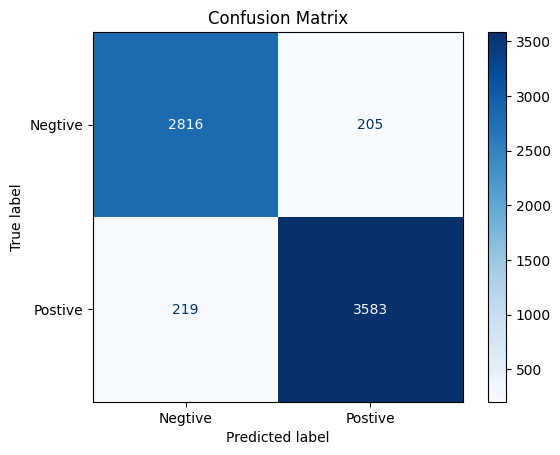

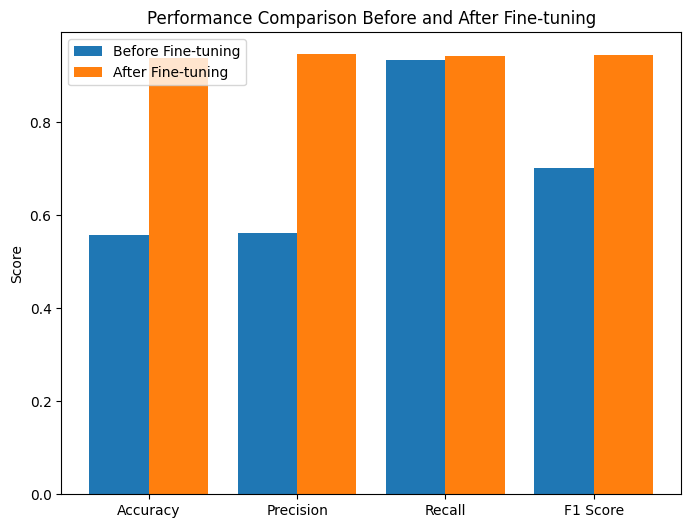

In [15]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()

# 测试模型效果
print("微调后的性能：")
final_metrics = evaluator.evaluate_model(model=model)

# 对比微调前后性能变化
compare_eval(initial_metrics, final_metrics)

### 对比

label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64
训练集长度: 54576; 验证集长度: 6822; 测试集长度: 6823
端到端的性能：
[DEBUG] Testing batch:0
[DEBUG] Testing batch:1
[DEBUG] Testing batch:2
[DEBUG] Testing batch:3
[DEBUG] Testing batch:4
[DEBUG] Testing batch:5
[DEBUG] Testing batch:6
Test Accuracy: 0.9484
Test Precision: 0.9559
Test Recall: 0.9513
Test F1 Score: 0.9536


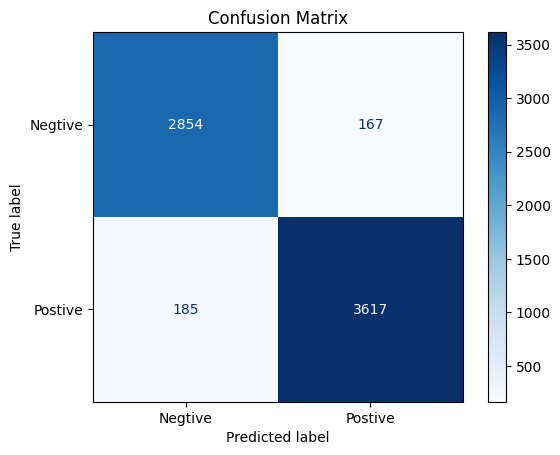

In [16]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier()
model.load_state_dict(torch.load(MODEL_E2E_NAME, map_location=device))
model.to(device)
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
_, _, test_loader = load_data(tokenizer, is_check=True)
evaluator = ModelEvaluator(test_loader=test_loader)
print("端到端的性能：")
e2e=evaluator.evaluate_model(model, is_check=True)
fpr_e2e, tpr_e2e, roc_auc_e2e = evaluator.fpr, evaluator.tpr, evaluator.roc_auc

Some weights of BertModel were not initialized from the model checkpoint at ./model/bert-base-uncased-mlm and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64
训练集长度: 54576; 验证集长度: 6822; 测试集长度: 6823
预训练&微调的性能：
[DEBUG] Testing batch:0
[DEBUG] Testing batch:1
[DEBUG] Testing batch:2
[DEBUG] Testing batch:3
[DEBUG] Testing batch:4
[DEBUG] Testing batch:5
[DEBUG] Testing batch:6
Test Accuracy: 0.9384
Test Precision: 0.9483
Test Recall: 0.9408
Test F1 Score: 0.9445


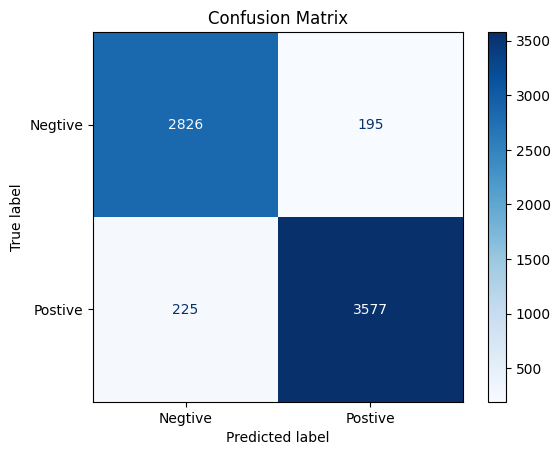

In [17]:
model = BertClassifier(mlm=True)
model.load_state_dict(torch.load(MODEL_PRE_NAME, map_location=device))
model.to(device)
tokenizer = BertTokenizer.from_pretrained(MODEL_PRE_PATH)
_, _, test_loader = load_data(tokenizer, is_check=True)
evaluator = ModelEvaluator(test_loader=test_loader)
print("预训练&微调的性能：")
mlm = evaluator.evaluate_model(model=model, is_check=True)
fpr_mlm, tpr_mlm, roc_auc_mlm = evaluator.fpr, evaluator.tpr, evaluator.roc_auc

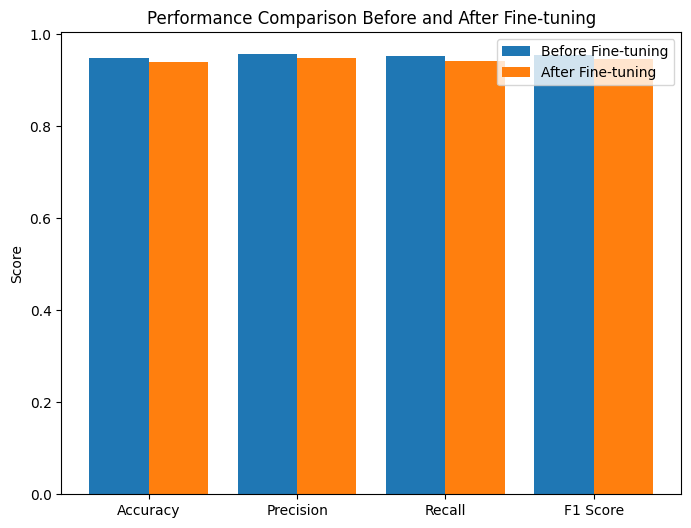

In [18]:
compare_eval(e2e, mlm)

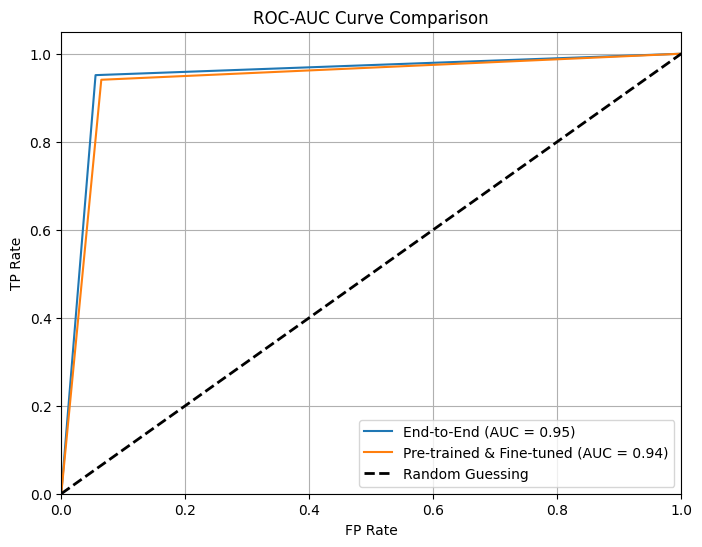

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_e2e, tpr_e2e, label=f"End-to-End (AUC = {roc_auc_e2e:.2f})")
plt.plot(fpr_mlm, tpr_mlm, label=f"Pre-trained & Fine-tuned (AUC = {roc_auc_mlm:.2f})")
plt.xlabel("False Positive Rate")
plt.plot([0, 1], [0, 1], "k--", lw=2, label="Random Guessing")
# 图形设置
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC-AUC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
if torch.cuda.is_available():
  torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier()
model.load_state_dict(torch.load(MODEL_E2E_NAME, map_location=device))
model.to(device)

tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)
_, _, test_loader = load_data(tokenizer, is_check=True)
#lengt=1000
#test_dataset = test_loader.dataset  # 获取原始数据集
#test_subset = Subset(test_dataset, list(range(lengt)))
#test_loader = DataLoader(test_subset, batch_size=test_loader.batch_size, shuffle=False)


evaluator = ModelEvaluator(test_loader=test_loader)

errors = evaluator.collect_errors(model=model, tokenizer=tokenizer)
print(f"使用的测试集大小：{len(test_loader.dataset)} | 错误分类样本数量: {len(errors)}")
for error in errors[:10]:
    print(f"Text: {error['text']}")
    print(f"True Label: {error['label']}, Pred: {error['pred']}")
    print("-" * 50)

label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64
训练集长度: 54576; 验证集长度: 6822; 测试集长度: 6823
[DEBUG] Testing batch:1
[DEBUG] Testing batch:2
[DEBUG] Testing batch:3
[DEBUG] Testing batch:4
[DEBUG] Testing batch:5
[DEBUG] Testing batch:6
[DEBUG] Testing batch:7
使用的测试集大小：6823 | 错误分类样本数量: 352
Text: based on theory sleightofhand and illwrought hypothesis
True Label: 1, Pred: 0
--------------------------------------------------
Text: downright transparent
True Label: 0, Pred: 1
--------------------------------------------------
Text: most of its ilk
True Label: 0, Pred: 1
--------------------------------------------------
Text: long after this film has ended
True Label: 1, Pred: 0
--------------------------------------------------
Text: hollywood excess
True Label: 0, Pred: 1
--------------------------------------------------
Text: than indecent proposal
True Label: 1, Pred: 0
-----------------------------------

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier()
model.load_state_dict(torch.load(MODEL_PRE_NAME, map_location=device))
model.to(device)

tokenizer = BertTokenizer.from_pretrained(MODEL_PRE_PATH)
_, _, test_loader = load_data(tokenizer, is_check=True)
#lengt=1000
#test_dataset = test_loader.dataset  # 获取原始数据集
#test_subset = Subset(test_dataset, list(range(lengt)))
#test_loader = DataLoader(test_subset, batch_size=test_loader.batch_size, shuffle=False)


evaluator = ModelEvaluator(test_loader=test_loader)

errors = evaluator.collect_errors(model=model, tokenizer=tokenizer)
print(f"使用的测试集大小：{len(test_loader.dataset)} | 错误分类样本数量: {len(errors)}")
for error in errors[:10]:
    print(f"Text: {error['text']}")
    print(f"True Label: {error['label']}, Pred: {error['pred']}")
    print("-" * 50)

label
1    0.557826
0    0.442174
Name: proportion, dtype: float64
label
1    0.509174
0    0.490826
Name: proportion, dtype: float64
训练集长度: 54576; 验证集长度: 6822; 测试集长度: 6823
[DEBUG] Testing batch:1
[DEBUG] Testing batch:2
[DEBUG] Testing batch:3
[DEBUG] Testing batch:4
[DEBUG] Testing batch:5
[DEBUG] Testing batch:6
[DEBUG] Testing batch:7
使用的测试集大小：6823 | 错误分类样本数量: 420
Text: the young stars are too cute
True Label: 1, Pred: 0
--------------------------------------------------
Text: this is an exercise not in biography but in hero worship
True Label: 0, Pred: 1
--------------------------------------------------
Text: that it ca nt help but engage an audience
True Label: 1, Pred: 0
--------------------------------------------------
Text: pulls no punches in its depiction of the lives of the papin sister and the events that led to their notorious rise to infamy
True Label: 1, Pred: 0
--------------------------------------------------
Text: a simpler leaner treatment would have been prefera